In [1]:
import pandas as pd
import bias
%matplotlib inline

# Load the data

## Corpus metadata

In [2]:
meta = pd.read_csv("data/metadata/metadata.csv", index_col="PMID")
meta.head(1)

,DOI,KEY,SOURCE,AUTHORS,YEAR,MONTH,JOURNAL,TITLE,PAGES,VOLUME,...,NUM_COORDINATES,MNI_COORDINATES,BRAINMAP_ID,BEHAVIORAL_DOMAIN,EXPERIMENT,DESCRIPTION,IMPACT_FACTOR_2018,CITATIONS,CITATIONS_PER_YEAR,N_SUBJECTS
PMID,,,,,,,,,,,,,,,,,,,,,
1402966,NaN,"Dolan R J, 1992",BrainMap,Dolan R J|Bench C J|Brown R G|Scott L C|Fristo...,1992,Sep,JOURNAL OF NEUROLOGY NEUROSURGERY & PSYCHIATRY,Regional cerebral blood flow abnormalities in ...,768-773,55,...,7.0,"-7.66,51.87,-8.33;-5.51,56.46,-4.28;-5.48,58.9...",6030020.0,"['Action.Rest', 'Action.Rest']","['Unimpaired > Impaired', 'Impaired > Unimpair...",Patients with depression who were cognitively ...,8.327,21,0.75,10.0


## Remove papers with missing data

In [3]:
(~meta["CITATIONS_PER_YEAR"].isna()).astype(int).sum()

18155

In [4]:
meta = meta.dropna(subset=["CITATIONS_PER_YEAR"])
len(meta)

18155

In [5]:
pmids = meta.index
len(pmids)

18155

## Activation coordinates

In [6]:
act = pd.read_csv("data/brain/coordinates.csv", index_col=0)
act = act.loc[pmids]
act.head(1)

,left_frontal_pole,left_insular_cortex,left_superior_frontal_gyrus,left_middle_frontal_gyrus,left_inferior_frontal_gyrus_pars_triangularis,left_inferior_frontal_gyrus_pars_opercularis,left_precentral_gyrus,left_temporal_pole,left_superior_temporal_gyrus_anterior_division,left_superior_temporal_gyrus_posterior_division,...,right_caudate,right_putamen,right_pallidum,right_hippocampus,right_amygdala,right_accumbens,right_brainstem,right_cerebellar_lobules,right_cerebellar_crus,right_cerebellar_vermis
PMID,,,,,,,,,,,,,,,,,,,,,
1402966,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
circuits = pd.read_csv("data/brain/clusters_data-driven_lr.csv", index_col=None)
structs = list(circuits["STRUCTURE"])
circuits.head(1)

,ORDER,CLUSTER,DOMAIN,STRUCTURE
0,1,6,MEMORY,left_amygdala


In [8]:
act = act[structs]
act_bin = (act > 0).astype(int)
act_bin.head()

,left_amygdala,left_hippocampus,left_inferior_temporal_gyrus_anterior_division,left_parahippocampal_gyrus_anterior_division,left_parahippocampal_gyrus_posterior_division,left_temporal_fusiform_cortex_anterior_division,right_amygdala,right_hippocampus,right_inferior_temporal_gyrus_anterior_division,right_inferior_temporal_gyrus_posterior_division,...,left_superior_temporal_gyrus_posterior_division,right_central_opercular_cortex,right_heschls_gyrus,right_middle_temporal_gyrus_anterior_division,right_middle_temporal_gyrus_posterior_division,right_parietal_operculum_cortex,right_planum_polare,right_planum_temporale,right_superior_temporal_gyrus_anterior_division,right_superior_temporal_gyrus_posterior_division
PMID,,,,,,,,,,,,,,,,,,,,,
1402966,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1410086,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1448149,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1486459,0,0,0,0,0,0,0,0,0,1,...,1,0,0,1,1,0,0,0,1,1
1486460,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,1


In [9]:
structs = [term.strip() for term in open("data/lexicon/lexicon_harvard-oxford.txt").readlines()]
act_uni = pd.DataFrame(0, index=pmids, columns=structs)
for struct in structs:
    if "left_" + struct in act.columns:
        act_uni[struct] = act["left_" + struct] + act["right_" + struct]
cerebellar_cols = [col for col in act.columns if "cerebellar" in col]
act_uni["cerebellum"] = act[cerebellar_cols].sum(axis=1) 
act_uni = (act_uni > 0).astype(int)
act_uni.head()

,accumbens,amygdala,angular_gyrus,brainstem,caudate,central_opercular_cortex,cerebellum,cingulate_gyrus_anterior_division,cingulate_gyrus_posterior_division,cuneal_cortex,...,superior_temporal_gyrus_posterior_division,supplementary_motor_cortex,supracalcarine_cortex,supramarginal_gyrus_anterior_division,supramarginal_gyrus_posterior_division,temporal_fusiform_cortex_anterior_division,temporal_fusiform_cortex_posterior_division,temporal_occipital_fusiform_cortex,temporal_pole,thalamus
PMID,,,,,,,,,,,,,,,,,,,,,
1402966,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1410086,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1448149,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1486459,0,0,1,0,0,0,0,0,1,1,...,1,0,1,0,1,0,1,1,1,0
1486460,0,0,1,0,0,0,0,1,0,1,...,1,1,1,0,1,0,0,0,0,0


## DTM for anatomical terms

In [10]:
dtm = pd.read_csv("data/text/dtm_fulltexts_anat-syns.csv.gz", index_col=0)
dtm = dtm.loc[pmids]
dtm.head(5)

,accumbens,amygdala,angular_gyrus,brainstem,caudate,central_opercular_cortex,cerebellum,cingulate_gyrus_anterior_division,cingulate_gyrus_posterior_division,cuneal_cortex,...,superior_temporal_gyrus_posterior_division,supplementary_motor_cortex,supracalcarine_cortex,supramarginal_gyrus_anterior_division,supramarginal_gyrus_posterior_division,temporal_fusiform_cortex_anterior_division,temporal_fusiform_cortex_posterior_division,temporal_occipital_fusiform_cortex,temporal_pole,thalamus
PMID,,,,,,,,,,,,,,,,,,,,,
1402966,0,1,0,0,3,0,26,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1410086,0,2,0,2,1,0,13,11,5,0,...,0,0,0,0,0,0,0,0,0,0
1448149,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1486459,0,0,0,0,2,0,0,2,5,0,...,0,2,0,0,0,0,0,0,0,0
1486460,0,0,0,0,5,0,0,4,0,2,...,1,0,0,0,0,0,0,0,0,0


In [11]:
dtm = dtm[structs]
dtm_bin = (dtm > 0).astype(int)
dtm_bin.shape

(18155, 57)

In [12]:
dtm_bin.head()

,accumbens,amygdala,angular_gyrus,brainstem,caudate,central_opercular_cortex,cerebellum,cingulate_gyrus_anterior_division,cingulate_gyrus_posterior_division,cuneal_cortex,...,superior_temporal_gyrus_posterior_division,supplementary_motor_cortex,supracalcarine_cortex,supramarginal_gyrus_anterior_division,supramarginal_gyrus_posterior_division,temporal_fusiform_cortex_anterior_division,temporal_fusiform_cortex_posterior_division,temporal_occipital_fusiform_cortex,temporal_pole,thalamus
PMID,,,,,,,,,,,,,,,,,,,,,
1402966,0,1,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1410086,0,1,0,1,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1448149,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1486459,0,0,0,0,1,0,0,1,1,0,...,0,1,0,0,0,0,0,0,0,0
1486460,0,0,0,0,1,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,0


# Assess encrichment in top articles

## Compute -log(p)

In [13]:
import numpy as np

In [14]:
n = meta["CITATIONS_PER_YEAR"].sort_values(ascending=False)
top_n = list(n.index[:int(len(n)/2)])
bot_n = list(n.index[int(len(n)/2):])
len(top_n)

9077

In [15]:
np.mean(meta.loc[top_n, "CITATIONS_PER_YEAR"])

4.934378993169532

In [16]:
np.std(meta.loc[top_n, "CITATIONS_PER_YEAR"])

5.659463055201816

In [17]:
len(bot_n)

9078

In [18]:
np.mean(meta.loc[bot_n, "CITATIONS_PER_YEAR"])

0.9366143914636493

In [19]:
np.std(meta.loc[bot_n, "CITATIONS_PER_YEAR"])

0.5072888653996039

In [20]:
df_coord = bias.compute_bias_fdr(act_bin, circuits["DOMAIN"], top_n, "citations_coord")
df_coord["STRUCTURE"] = df_coord["TERM"]
df_coord["TERM"] = [term.replace("_anterior", ",_anterior").replace("_posterior", ",_posterior").replace("heschl", "heschl'") for term in df_coord["TERM"]]
df_coord["TERM"] = [term.replace("left_", "") + " (L)" if "left_" in term else term for term in df_coord["TERM"] ]
df_coord["TERM"] = [term.replace("right_", "") + " (R)" if "right_" in term else term for term in df_coord["TERM"]]
df_coord["TERM"] = [term.replace("_", " ") for term in df_coord["TERM"]]
df_coord.sort_values("FDR").head()

,TERM,DOMAIN,P,-log10(P),FDR,ORDER,STRUCTURE
6,amygdala (R),MEMORY,2.032843e-20,19.691896,2.398755e-18,0,right_amygdala
25,frontal medial cortex (R),REWARD,4.207654e-20,19.375960,2.482516e-18,1,right_frontal_medial_cortex
0,amygdala (L),MEMORY,1.922562e-16,15.716120,7.562076e-15,0,left_amygdala
17,frontal medial cortex (L),REWARD,1.438493e-15,14.842092,4.243554e-14,1,left_frontal_medial_cortex
28,subcallosal cortex (R),REWARD,1.535677e-14,13.813700,3.624199e-13,1,right_subcallosal_cortex


## Plot -log(p)

In [22]:
import numpy as np
from style import style

In [21]:
fdr_thres = 1e-6

In [23]:
df_coord_thres = df_coord.loc[df_coord["FDR"] < fdr_thres]
len(df_coord_thres)

27

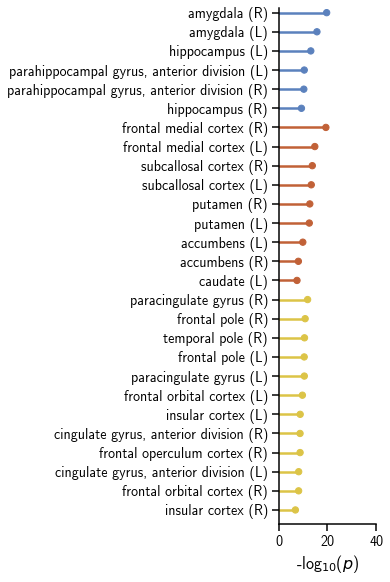

In [24]:
bias.plot_dots(df_coord_thres, "citations_coord", xrange=list(range(0,50,20)), 
               height=9.5, width=1.75, font_size=14)

In [25]:
labs = pd.read_csv("data/brain/labels.csv")["PREPROCESSED"]
df = pd.DataFrame({"citations_coord_brain": df_coord["-log10(P)"].values})
df.index = df_coord["STRUCTURE"]
df["citations_coord_brain"].values[df_coord["FDR"] >= fdr_thres] = np.nan
df = df.loc[labs]

/anaconda3/envs/ontol/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)



citations_coord_brain


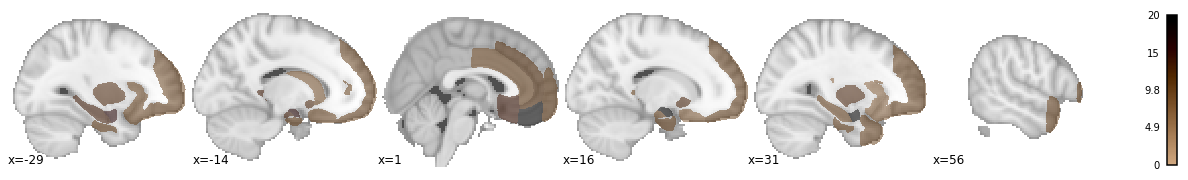


citations_coord_brain


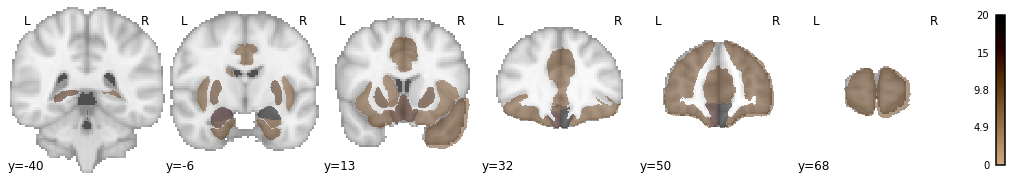


citations_coord_brain


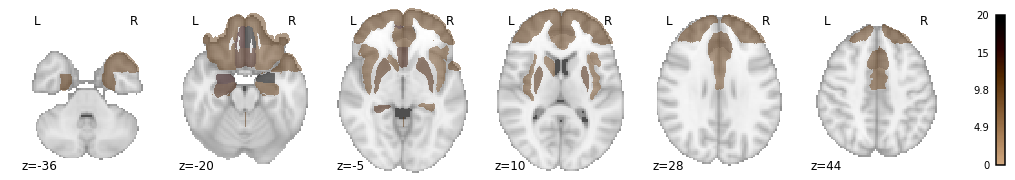

In [26]:
atlas = bias.load_atlas(path="data")
for plane in ["x", "y", "z"]:
    bias.map_plane(df, atlas, "figures", plane=plane, cut_coords=6, 
                   cbar=True, cmaps=[style.make_cmap(style.c["brown"])], 
                   suffix="_" + plane, print_fig=True, verbose=False)

# Plot coordinates vs. full texts

In [27]:
import numpy as np
from style import style

In [28]:
terms = set(dtm.columns)
freq = pd.DataFrame({"coordinates": act_uni[terms].sum(), "full_texts": dtm[terms].sum()})
freq.sort_values("full_texts", ascending=False).head(10)

,coordinates,full_texts
insular_cortex,8978,194711
amygdala,4285,120420
hippocampus,5834,91985
cerebellum,7873,91889
cingulate_gyrus_anterior_division,10363,60535
thalamus,6576,59499
middle_frontal_gyrus,12140,58837
caudate,4839,49447
precuneous_cortex,10120,45145
supplementary_motor_cortex,7577,40204


In [29]:
term2colors = {struct: [] for struct in structs}
for struct in structs:
    for bilat_struct, dom in zip(circuits["STRUCTURE"], circuits["DOMAIN"]):
        bilat_struct = bilat_struct.replace("cerebellar", "cerebellum")
        color = style.c[style.fw2c["data-driven"][style.order["data-driven"].index(dom)]]
        if struct in bilat_struct and color not in term2colors[struct]:
            term2colors[struct].append(color)

In [30]:
line_func = np.poly1d(np.polyfit(freq["coordinates"], freq["full_texts"], 1))
residuals = []
for x, y in zip(freq["coordinates"], freq["full_texts"]):
    y_pred = line_func(x)
    residual = y - y_pred
    residuals.append(residual)
freq["residual"] = residuals
freq.sort_values("residual", ascending=False).head()

,coordinates,full_texts,residual
insular_cortex,8978,194711,171624.341867
amygdala,4285,120420,103583.521363
hippocampus,5834,91985,73085.549268
cerebellum,7873,91889,70273.990779
thalamus,6576,59499,39611.347013


In [31]:
terms_to_label = freq["residual"].sort_values().index[-3:]
terms_to_label

Index(['hippocampus', 'amygdala', 'insular_cortex'], dtype='object')

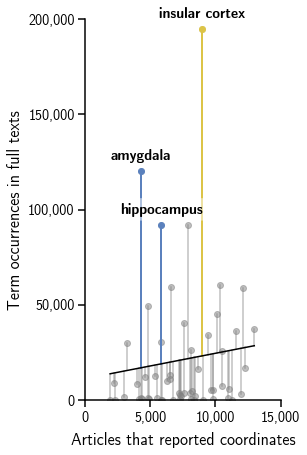

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams
from style import style

font = style.font
font_bold = style.font_bold

prop_ax = font_manager.FontProperties(fname=font, size=14)
prop_dot = font_manager.FontProperties(fname=font_bold, size=14)
prop_lab = font_manager.FontProperties(fname=font, size=16)

rcParams["axes.linewidth"] = 1.5

fig, ax = plt.subplots(figsize=(3.5, 7))

x = freq["coordinates"]
y = freq["full_texts"]

plt.scatter(x, y, color="gray", alpha=0.5)

line_x = np.unique(x)
line_y = line_func(line_x)
for x, y in zip(freq["coordinates"], freq["full_texts"]):
    plt.plot([x, x], [y, line_func(x)], color="gray", alpha=0.5, linewidth=1.5)

for term in terms_to_label:
    row = freq.loc[term]
    x = row["coordinates"]
    y = row["full_texts"]
    plt.text(x, y+6000, term.replace("_", " "), fontproperties=prop_dot, ha="center",
             bbox=dict(facecolor="white", alpha=0.5, edgecolor="white", linewidth=0, boxstyle="round"))
    plt.scatter(x, y, color="white", alpha=1)
    plt.plot([x, x], [y, line_func(x)], color="white", alpha=1, linewidth=1.5)
    for color in term2colors[term]:
        plt.plot([x, x], [y, line_func(x)], color=color, alpha=1, linewidth=2)
        plt.scatter(x, y, color=color, alpha=1)

plt.plot(line_x, line_y, color="black", alpha=1, linewidth=1.5)
        
ax.set_xticks(range(0, 16000, 5000))
ax.set_yticks(range(0, 250000, 50000))

ax.set_xticklabels([format(v, ",d") for v in range(0, 16000, 5000)], fontproperties=prop_ax)
ax.set_yticklabels([format(v, ",d") for v in range(0, 250000, 50000)], fontproperties=prop_ax)

plt.xlim([0, 15000])
plt.ylim([0, 200000])

for side in ["right", "top"]:
    ax.spines[side].set_visible(False)

ax.xaxis.set_tick_params(width=1.5, length=7)
ax.yaxis.set_tick_params(width=1.5, length=7)

ax.set_xlabel("Articles that reported coordinates", fontproperties=prop_lab, labelpad=7.5)
ax.set_ylabel("Term occurrences in full texts", fontproperties=prop_lab, labelpad=5)

plt.savefig("figures/occ_coord_full.png", dpi=250, bbox_inches="tight")
plt.show()

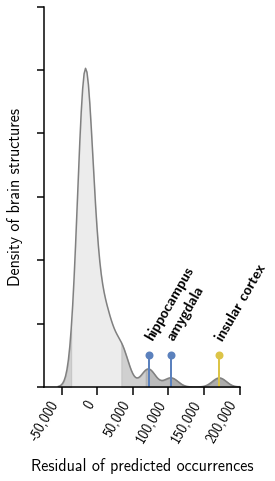

In [33]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams
from style import style
import seaborn as sns

font = style.font
font_bold = style.font_bold

prop_ax = font_manager.FontProperties(fname=font, size=14)
prop_dot = font_manager.FontProperties(fname=font_bold, size=14)
prop_lab = font_manager.FontProperties(fname=font, size=16)

rcParams["axes.linewidth"] = 1.5


fig, ax = plt.subplots(figsize=(3.5, 7))

sns.distplot(freq["residual"], hist=False, kde=True, 
             bins=20, color="gray", 
             hist_kws={"edgecolor":"black"},
             kde_kws={"linewidth": 1.5, "color":"gray"})

l = ax.lines[0]
x = l.get_xydata()[:,0]
y = l.get_xydata()[:,1]

mu = np.mean(freq["residual"])
sd = np.std(freq["residual"])

ax.fill_between(x, y, color="gray", alpha=0.15)

for n_sd in range(-3, 0):
    pos = mu + (n_sd * sd)
    closest_x = min(x, key=lambda list_value : abs(list_value - pos))
    idx = list(x).index(closest_x)
    ax.fill_between(x[:idx], y[:idx], color="gray", alpha=0.25)

for n_sd in range(1, 4):
    pos = mu + (n_sd * sd)
    closest_x = min(x, key=lambda list_value : abs(list_value - pos))
    idx = list(x).index(closest_x)
    ax.fill_between(x[idx-1:], y[idx-1:], color="gray", alpha=0.25)

for term in terms_to_label:
    row = freq.loc[term]
    x = row["residual"]
    y = 0.0000025
    plt.text(x-8500, y+0.00000125, term.replace("_", " "), rotation=60, fontproperties=prop_dot, ha="left")
    for color in term2colors[term]:
        plt.plot([x, x], [0, y], color=color, linewidth=2)
        plt.scatter(x, y, color=color, linewidth=2)
    
ax.set_xlim([-75000, 200000])
ax.set_ylim([0, 0.00003])

ax.set_xticklabels([format(int(v), ",d") for v in plt.xticks()[0]], 
                   rotation=60, fontproperties=prop_ax, ha="right")
ax.set_yticklabels([], fontproperties=prop_ax)

for side in ["right", "top"]:
    ax.spines[side].set_visible(False)

ax.xaxis.set_tick_params(width=1.5, length=7.5)
ax.yaxis.set_tick_params(width=1.5, length=7.5)

ax.set_xlabel("Residual of predicted occurrences", fontproperties=prop_lab, labelpad=12.5)
ax.set_ylabel("Density of brain structures", fontproperties=prop_lab, labelpad=10)

plt.savefig("figures/resid_coord_full.png", dpi=250, bbox_inches="tight")
plt.show()

# Relate citations with occurrences

In [34]:
from scipy import stats

In [35]:
cor_coord = []
for term in terms:
    occs = act_uni[term].astype(float)
    if len(occs.shape) > 1:
        occs = occs.loc[:,~occs.columns.duplicated()]
    r, p = stats.spearmanr(occs, meta["CITATIONS"].astype(float))
    if r > 0 and p < 0.001:
        print("{:45s} r={:1.4f} p={:1.4f}".format(term, r, p))
    cor_coord.append(r)

middle_frontal_gyrus                          r=0.0250 p=0.0008
heschls_gyrus                                 r=0.0374 p=0.0000
angular_gyrus                                 r=0.0265 p=0.0004
cerebellum                                    r=0.0321 p=0.0000
frontal_pole                                  r=0.0485 p=0.0000
central_opercular_cortex                      r=0.0503 p=0.0000
parietal_operculum_cortex                     r=0.0295 p=0.0001
supramarginal_gyrus_posterior_division        r=0.0324 p=0.0000
parahippocampal_gyrus_anterior_division       r=0.0490 p=0.0000
supplementary_motor_cortex                    r=0.0379 p=0.0000
thalamus                                      r=0.0745 p=0.0000
brainstem                                     r=0.0604 p=0.0000
temporal_fusiform_cortex_anterior_division    r=0.0268 p=0.0003
insular_cortex                                r=0.0609 p=0.0000
superior_temporal_gyrus_posterior_division    r=0.0318 p=0.0000
temporal_occipital_fusiform_cortex      

In [36]:
cor_full = []
for term in terms:
    occs = dtm[term].astype(float)
    if len(occs.shape) > 1:
        occs = occs.loc[:,~occs.columns.duplicated()]
    r, p = stats.spearmanr(occs, meta["CITATIONS"].astype(float))
    if r > 0 and p < 0.001:
        print("{:45s} r={:1.4f} p={:1.4f}".format(term, r, p))
    cor_full.append(r)

heschls_gyrus                                 r=0.0320 p=0.0000
frontal_pole                                  r=0.0776 p=0.0000
thalamus                                      r=0.0685 p=0.0000
brainstem                                     r=0.0681 p=0.0000
accumbens                                     r=0.0518 p=0.0000
cingulate_gyrus_anterior_division             r=0.0877 p=0.0000
caudate                                       r=0.0957 p=0.0000
pallidum                                      r=0.0320 p=0.0000
frontal_operculum_cortex                      r=0.0428 p=0.0000
amygdala                                      r=0.0487 p=0.0000
inferior_frontal_gyrus_pars_opercularis       r=0.0402 p=0.0000
subcallosal_cortex                            r=0.0574 p=0.0000
frontal_orbital_cortex                        r=0.0461 p=0.0000
inferior_frontal_gyrus_pars_triangularis      r=0.0248 p=0.0009
cingulate_gyrus_posterior_division            r=0.0297 p=0.0001


In [37]:
cor = pd.DataFrame({"full_texts": cor_full, "coordinates": cor_coord}, index=terms)
cor = cor.fillna(0.0)
cor.sort_values("full_texts", ascending=False).head(10)

,full_texts,coordinates
caudate,0.095685,0.038795
cingulate_gyrus_anterior_division,0.087734,0.066052
frontal_pole,0.077590,0.048526
thalamus,0.068530,0.074508
brainstem,0.068087,0.060424
subcallosal_cortex,0.057364,0.058818
accumbens,0.051755,0.047470
amygdala,0.048699,0.066746
frontal_orbital_cortex,0.046085,0.065852
frontal_operculum_cortex,0.042847,0.066896


In [38]:
line_func = np.poly1d(np.polyfit(cor["coordinates"], cor["full_texts"], 1))
residuals = []
for x, y in zip(cor["coordinates"], cor["full_texts"]):
    y_pred = line_func(x)
    residual = y - y_pred
    residuals.append(residual)
cor["residual"] = residuals
cor.sort_values("residual", ascending=False).head(10)

,full_texts,coordinates,residual
caudate,0.095685,0.038795,0.088489
frontal_pole,0.077590,0.048526,0.058361
cingulate_gyrus_anterior_division,0.087734,0.066052,0.046831
cingulate_gyrus_posterior_division,0.029667,0.021002,0.044472
lateral_occipital_cortex_superior_division,0.014200,0.015618,0.035664
brainstem,0.068087,0.060424,0.034145
accumbens,0.051755,0.047470,0.033831
occipital_pole,-0.004334,0.005028,0.030225
inferior_temporal_gyrus_posterior_division,0.004599,0.012326,0.030133
inferior_temporal_gyrus_anterior_division,0.006349,0.014834,0.028783
